# Study of the learned W vector in the linear AdaTS model

In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
import os
import sys
import time
sys.path.extend(['..'])

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from scipy.stats import entropy
import torch
import torch.nn as nn
from torch.nn.functional import softplus
from torch.utils.data import DataLoader
from torchvision import transforms

%aimport models
from models import TempScaling, AdaTS, LinearT, HbasedT, DNNbasedT, HlogbasedT, HistTS
%aimport utils
from utils import compare_results, calib_split, torch_entropy, binByEntropy, load_precomputedlogits, compute_ece, compute_nll, compute_brier, get_CIFAR10_C, NumpyDataset, predict_logits, load_model
%aimport adats_utils
from adats_utils import fitAdaTS

In [4]:
%matplotlib inline

In [5]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amssymb}')

## Load data RESNET50

In [6]:
CIFAR10_PATH = '../../data/CIFAR10'
MODEL_PATH = '../../trained_models/CIFAR10/resnet50'

In [7]:
Z_train = np.load(os.path.join(MODEL_PATH, 'train_logits.npy'))
Z_val = np.load(os.path.join(MODEL_PATH, 'val_logits.npy'))
Z_test = np.load(os.path.join(MODEL_PATH, 'test_logits.npy'))

P_train = softmax(Z_train, axis=1)
P_val = softmax(Z_val, axis=1)
P_test = softmax(Z_test, axis=1)

y_train = np.load(os.path.join(CIFAR10_PATH, 'train_labels.npy'))
y_val = np.load(os.path.join(CIFAR10_PATH, 'val_labels.npy'))
y_test = np.load(os.path.join(CIFAR10_PATH, 'test_labels.npy'))

In [8]:
N, dim = Z_train.shape

### Train Temp-Scaling Models

In [9]:
### Temp-Scal as baseline:
tempScaler = TempScaling()
tempScaler.fit(Z_val, y_val, v=True);

In [10]:
laTempScaler = AdaTS(LinearT(dim))
laTempScaler = fitAdaTS(laTempScaler, Z_val, y_val, epochs=10000, batch_size=1000, lr=1e-3, v=True)

In [11]:
print('##### Results on train set:')
compare_results(predictions={'Uncal': softmax(Z_train, axis=1),
                             'TempScal': tempScaler.predictive(Z_train),
                             'LinearAdaptiveTempScal': laTempScaler.predictive(Z_train)}, target=y_train, from_logits=False);

##### Results on train set:
             Calibrator      Accuracy           ECE           MCE   Brier Score           NLL
Uncal                           99.94%         0.11%        45.80%    1.104e-03     2.701e-03
TempScal                        99.94%         5.35%        65.23%    8.604e-03     5.811e-02
LinearAdaptiveTempScal          99.94%         5.30%        72.01%    9.400e-03     5.805e-02


In [12]:
print('##### Results on validation set:')
compare_results(predictions={'Uncal': softmax(Z_val, axis=1),
                             'TempScal': tempScaler.predictive(Z_val),
                             'LinearAdaptiveTempScal': laTempScaler.predictive(Z_val)}, target=y_val, M=15, from_logits=False);

##### Results on validation set:
             Calibrator      Accuracy           ECE           MCE   Brier Score           NLL
Uncal                           86.72%        10.30%        73.80%    2.300e-01     7.737e-01
TempScal                        86.72%         2.49%        55.51%    1.967e-01     4.343e-01
LinearAdaptiveTempScal          86.72%         2.54%        25.89%    1.947e-01     4.278e-01


In [13]:
print('##### Results on test set:')
compare_results(predictions={'Uncal': softmax(Z_test, axis=1),
                             'TempScal': tempScaler.predictive(Z_test),
                             'LinearAdaptiveTempScal': laTempScaler.predictive(Z_test)}, target=y_test, M=15, from_logits=False);

##### Results on test set:
             Calibrator      Accuracy           ECE           MCE   Brier Score           NLL
Uncal                           86.13%        10.69%        35.80%    2.392e-01     7.897e-01
TempScal                        86.13%         2.35%        16.93%    2.037e-01     4.473e-01
LinearAdaptiveTempScal          86.13%         2.15%        18.34%    2.019e-01     4.399e-01


## Class-wise calibration

In [14]:
preds_train = np.argmax(Z_train, axis=1)
preds_val = np.argmax(Z_val, axis=1)
preds_test = np.argmax(Z_test, axis=1)
    
P_train_TS = tempScaler.predictive(Z_train)
P_val_TS = tempScaler.predictive(Z_val)
P_test_TS = tempScaler.predictive(Z_test)


P_train_lTS = laTempScaler.predictive(Z_train)
P_val_lTS = laTempScaler.predictive(Z_val)
P_test_lTS = laTempScaler.predictive(Z_test)

### Temperature per class

In [15]:
Ts_val = laTempScaler.get_T(Z_val)
Ts_test = laTempScaler.get_T(Z_test)

In [16]:
### Optimum T per class

T_c = np.zeros(10)
for c in range(10):
    ts_aux = TempScaling()
    ts_aux.fit(Z_test[y_test==c], y_test[y_test==c]);
    T_c[c] = ts_aux.T.detach().numpy()

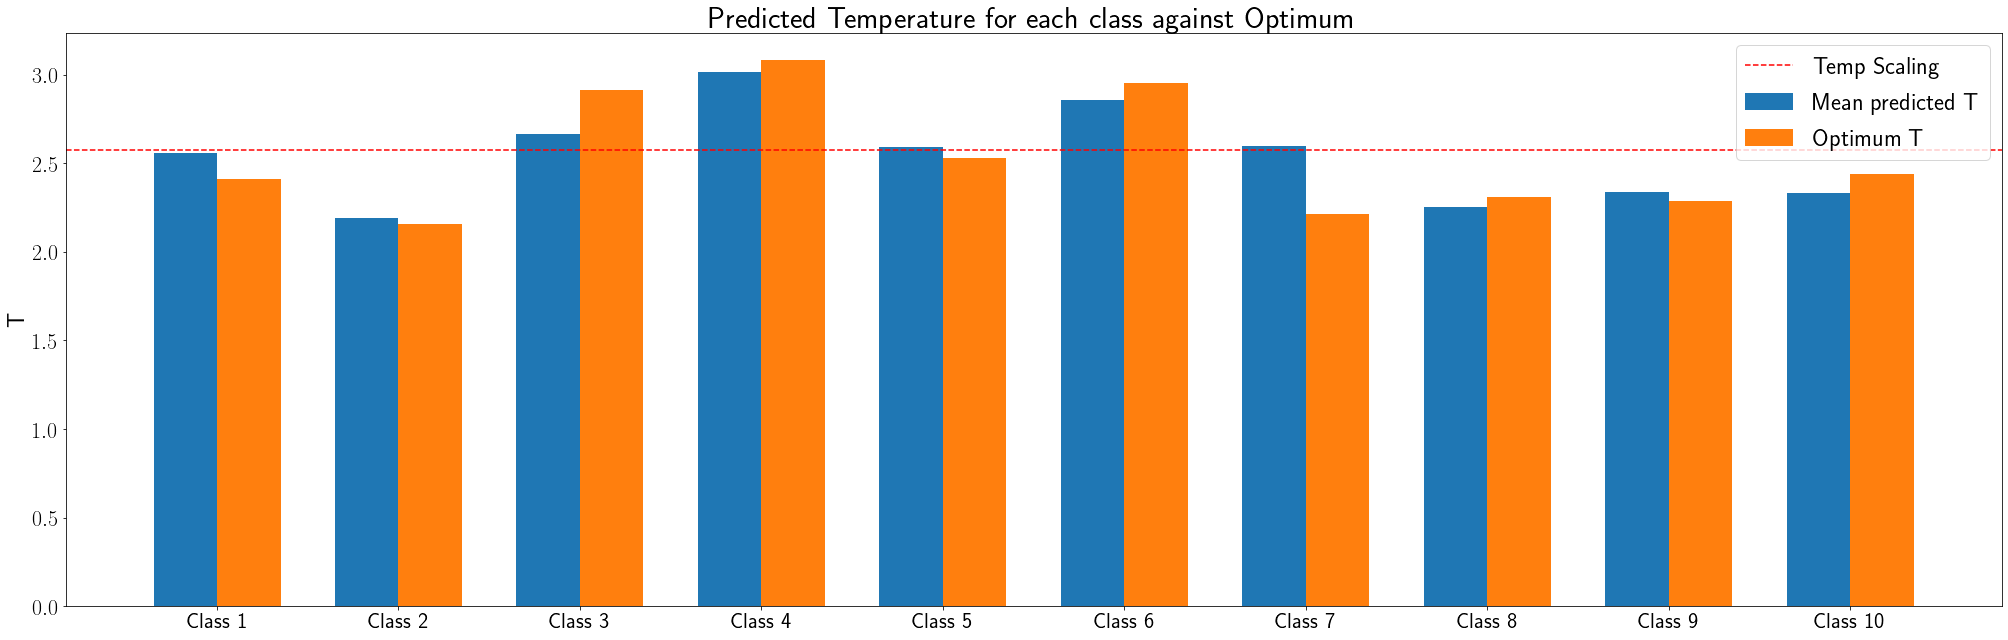

In [17]:
labels = ['Class {:d}'.format(i+1) for i in range(10)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars


fig, ax = plt.subplots(figsize=(28, 9))

rects1 = ax.bar(x - width/2, [np.mean(Ts_test[y_test==c]) for c in range(10)], width, label='Mean predicted T')
rects2 = ax.bar(x + width/2, T_c, width, label='Optimum T')
ax.axhline(tempScaler.T.item(), c='red', ls='--', label='Temp Scaling')
ax.set_title('Predicted Temperature for each class against Optimum', fontsize=30)


ax.set_ylabel('T', fontsize=24)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.tick_params(axis='both', labelsize=22)
ax.legend(fontsize=24)

plt.tight_layout()
plt.show();

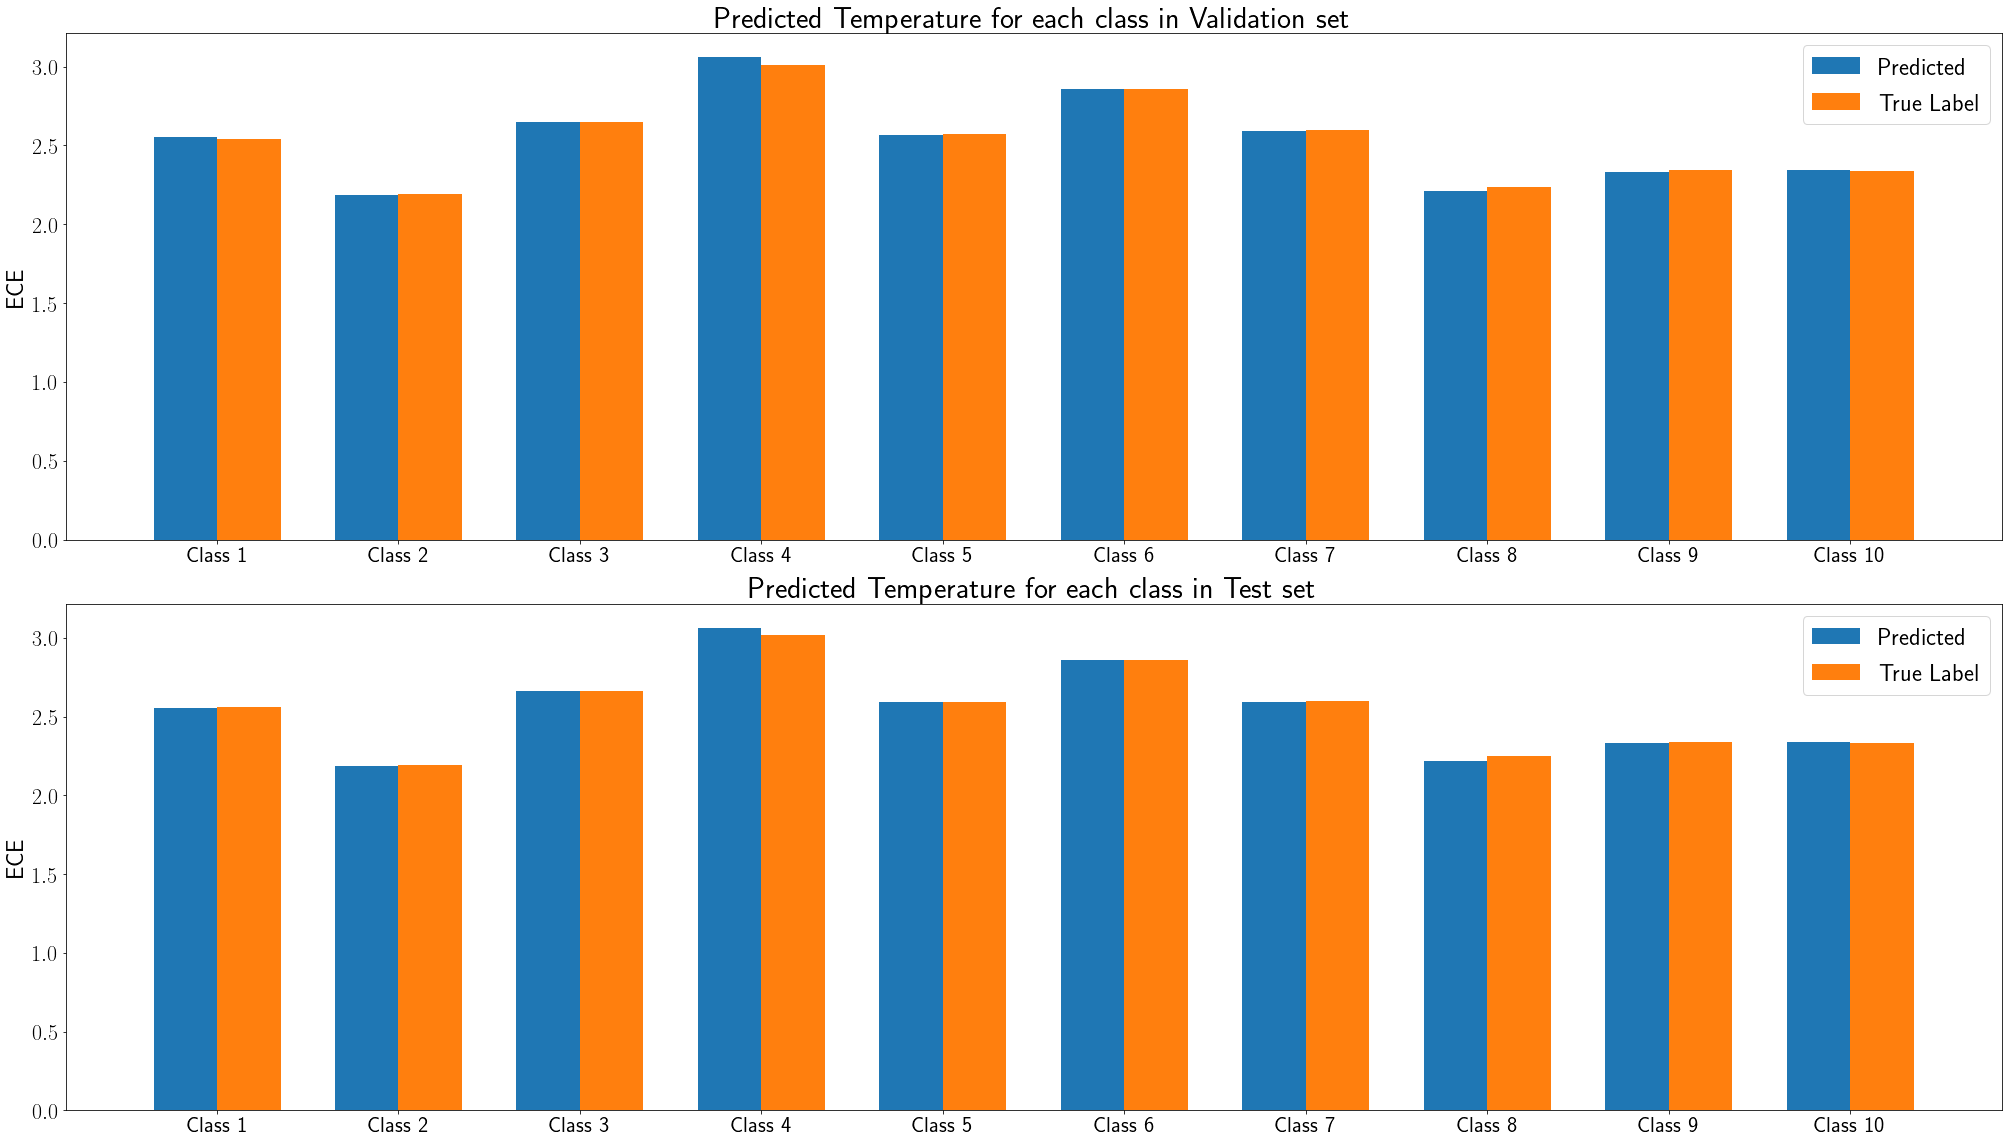

In [18]:
labels = ['Class {:d}'.format(i+1) for i in range(10)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars


fig, ax = plt.subplots(2, 1, figsize=(28, 16))

rects1 = ax[0].bar(x - width/2, [np.mean(Ts_val[preds_val==c]) for c in range(10)], width, label='Predicted')
rects2 = ax[0].bar(x + width/2, [np.mean(Ts_val[y_val==c]) for c in range(10)], width, label='True Label')
ax[0].set_title('Predicted Temperature for each class in Validation set', fontsize=30)

rects1 = ax[1].bar(x - width/2, [np.mean(Ts_test[preds_test==c]) for c in range(10)], width, label='Predicted')
rects2 = ax[1].bar(x + width/2, [np.mean(Ts_test[y_test==c]) for c in range(10)], width, label='True Label')
ax[1].set_title('Predicted Temperature for each class in Test set', fontsize=30)



for _ax in ax.flatten():
    _ax.set_ylabel('ECE', fontsize=24)
    _ax.set_xticks(x)
    _ax.set_xticklabels(labels)
    _ax.tick_params(axis='both', labelsize=22)
    _ax.legend(fontsize=24)

plt.tight_layout()
plt.show();

### Measures of calibration

In [19]:
### ECE
ece_uncal = np.zeros(10)
ece_TS = np.zeros(10)
ece_lTS = np.zeros(10)

for c in range(10):
    ix = y_test==c
    ece_uncal[c] = compute_ece(P_test[ix], y_test[ix])
    ece_TS[c] = compute_ece(P_test_TS[ix], y_test[ix])
    ece_lTS[c] = compute_ece(P_test_lTS[ix], y_test[ix])

In [20]:
### NLL
nll_uncal = np.zeros(10)
nll_TS = np.zeros(10)
nll_lTS = np.zeros(10)

for c in range(10):
    ix = y_test==c
    nll_uncal[c] = compute_nll(P_test[ix], y_test[ix], from_logits=False)
    nll_TS[c] = compute_nll(P_test_TS[ix], y_test[ix], from_logits=False)
    nll_lTS[c] = compute_nll(P_test_lTS[ix], y_test[ix], from_logits=False)

In [21]:
### Brier
bri_uncal = np.zeros(10)
bri_TS = np.zeros(10)
bri_lTS = np.zeros(10)

for c in range(10):
    ix = y_test==c
    bri_uncal[c] = compute_brier(P_test[ix], y_test[ix])
    bri_TS[c] = compute_brier(P_test_TS[ix], y_test[ix])
    bri_lTS[c] = compute_brier(P_test_lTS[ix], y_test[ix])

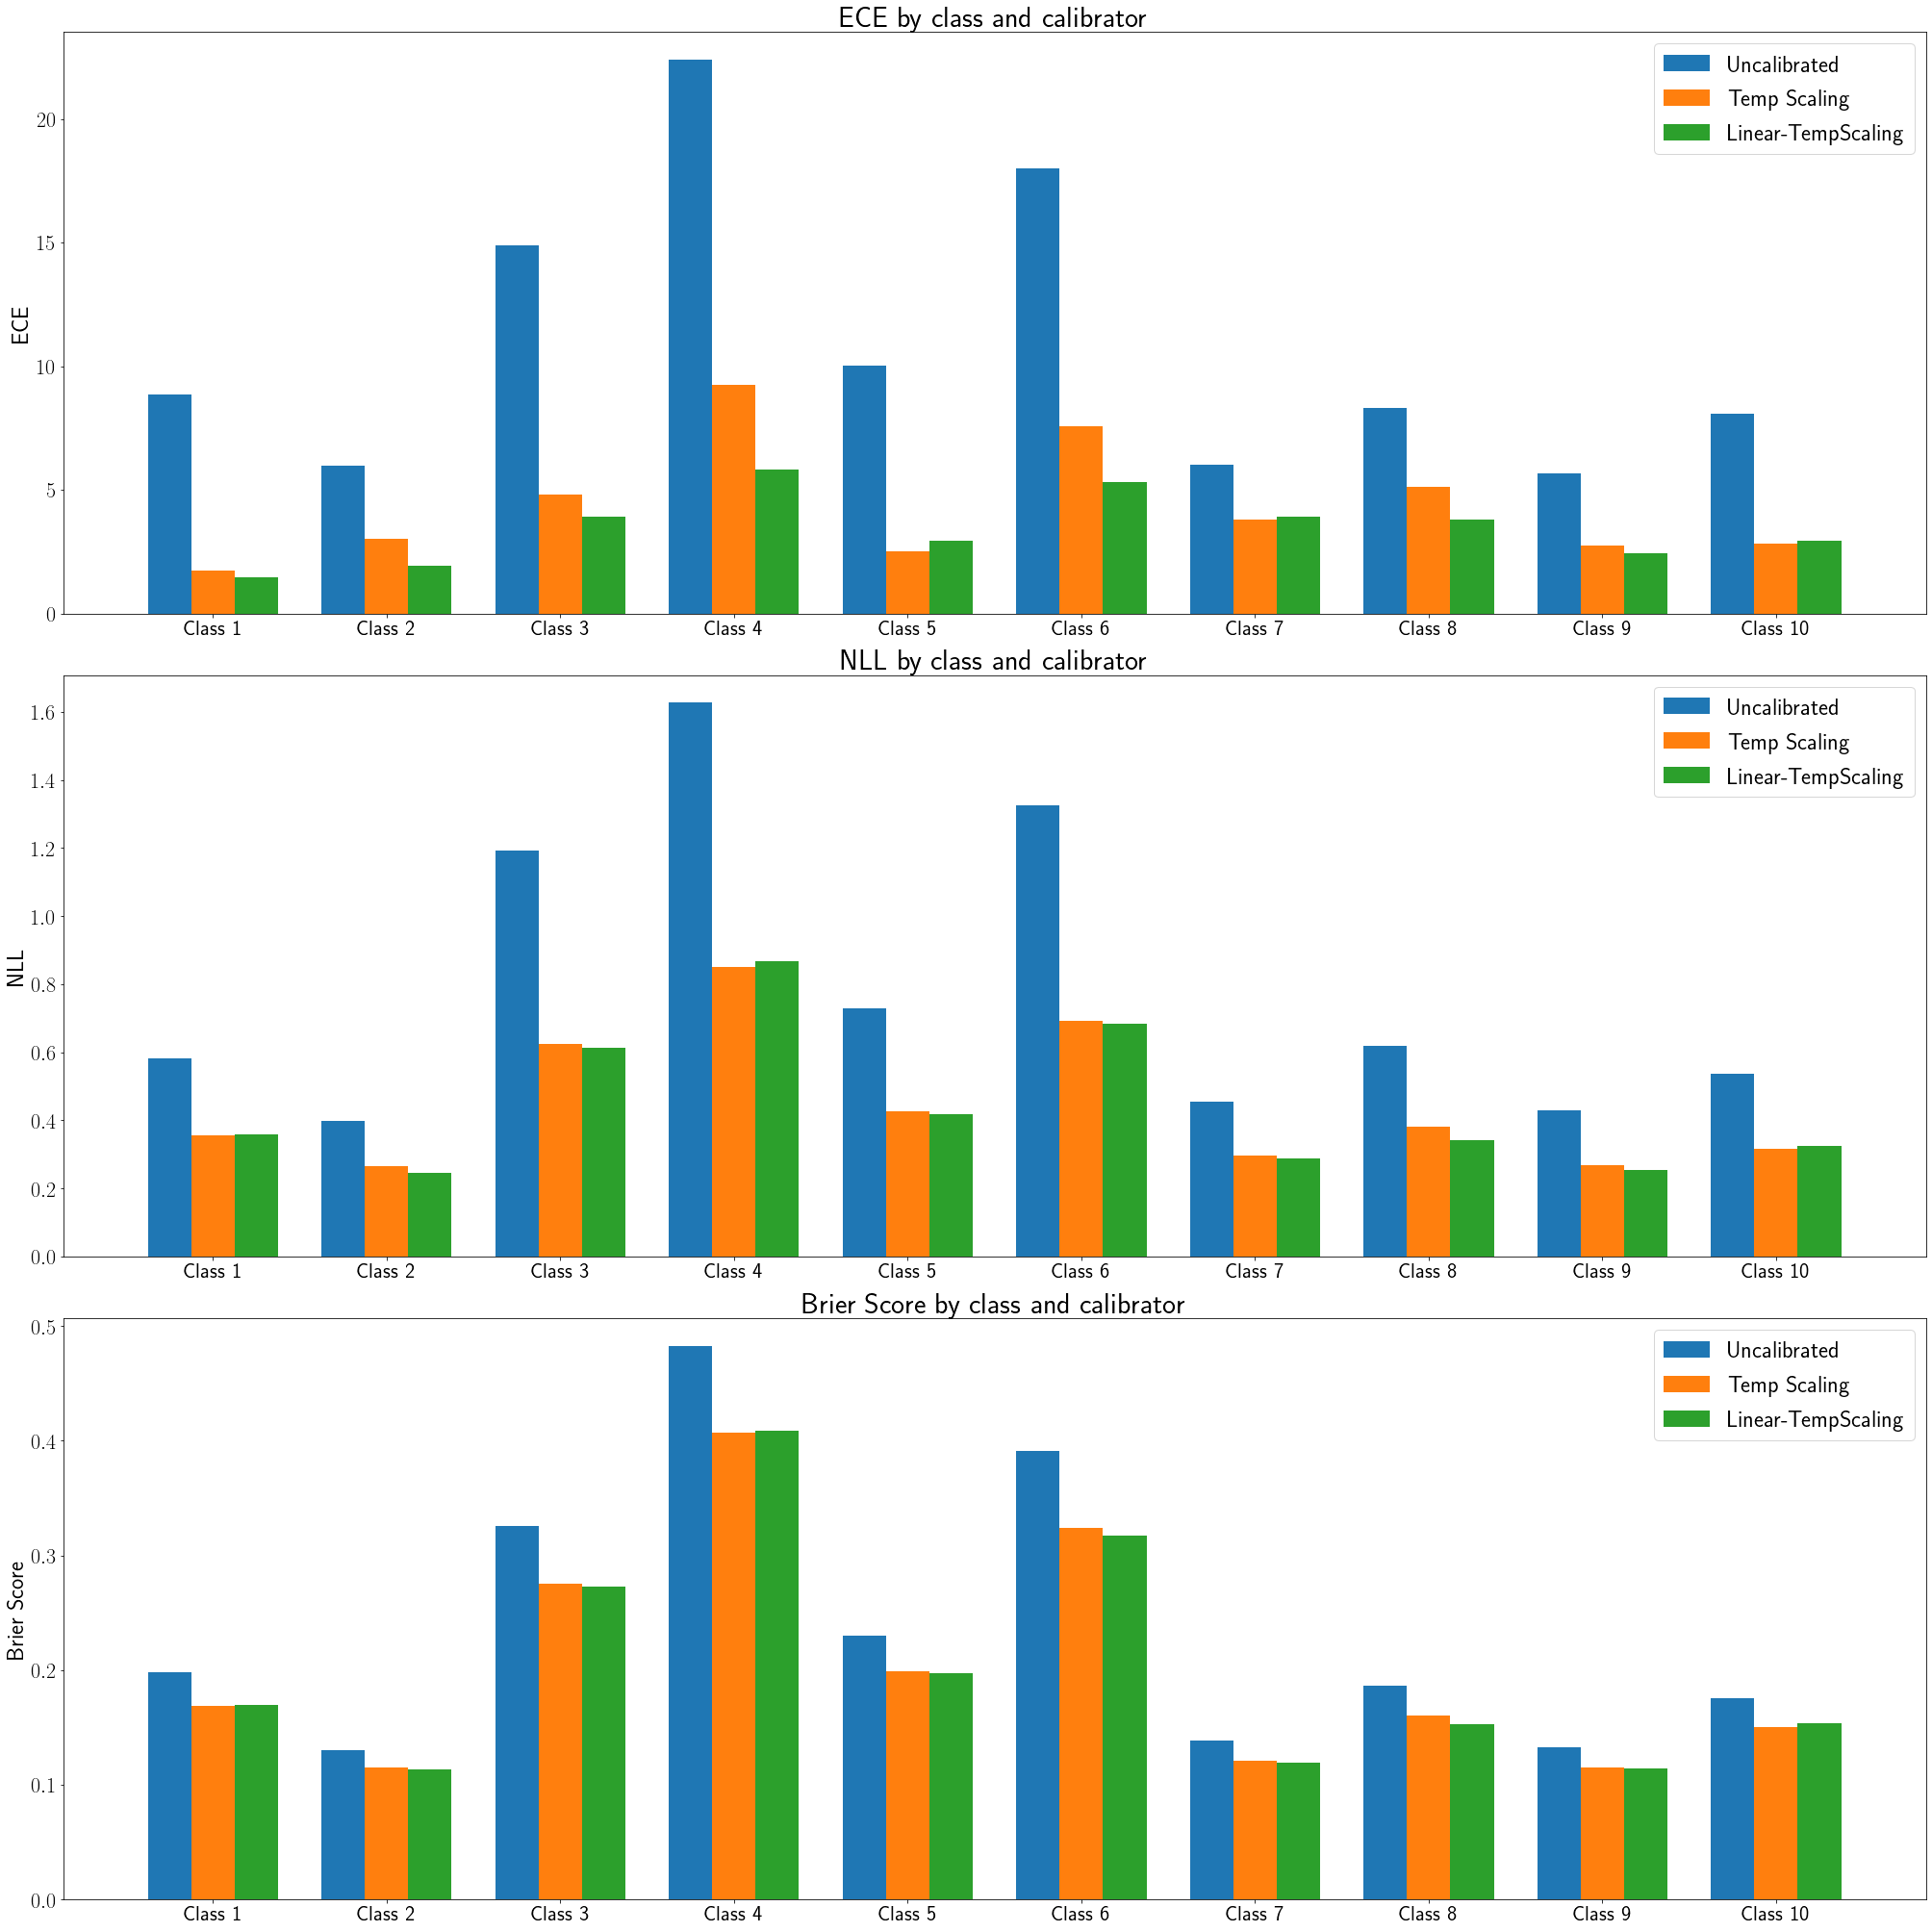

In [22]:
labels = ['Class {:d}'.format(i+1) for i in range(10)]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars


fig, ax = plt.subplots(3, 1, figsize=(28, 28))

# ECE
rects1 = ax[0].bar(x - width, ece_uncal, width, label='Uncalibrated')
rects2 = ax[0].bar(x, ece_TS, width, label='Temp Scaling')
rects3 = ax[0].bar(x + width, ece_lTS, width, label='Linear-TempScaling')

ax[0].set_ylabel('ECE', fontsize=24)
ax[0].set_title('ECE by class and calibrator', fontsize=30)


# NLL
rects1 = ax[1].bar(x - width, nll_uncal, width, label='Uncalibrated')
rects2 = ax[1].bar(x, nll_TS, width, label='Temp Scaling')
rects3 = ax[1].bar(x + width, nll_lTS, width, label='Linear-TempScaling')

ax[1].set_ylabel('NLL', fontsize=24)
ax[1].set_title('NLL by class and calibrator', fontsize=30)


# Brier
rects1 = ax[2].bar(x - width, bri_uncal, width, label='Uncalibrated')
rects2 = ax[2].bar(x, bri_TS, width, label='Temp Scaling')
rects3 = ax[2].bar(x + width, bri_lTS, width, label='Linear-TempScaling')

ax[2].set_ylabel('Brier Score', fontsize=24)
ax[2].set_title('Brier Score by class and calibrator', fontsize=30)


for _ax in ax.flatten():
    _ax.set_xticks(x)
    _ax.set_xticklabels(labels)
    _ax.tick_params(axis='both', labelsize=22)
    _ax.legend(fontsize=24)

plt.tight_layout()
plt.show();

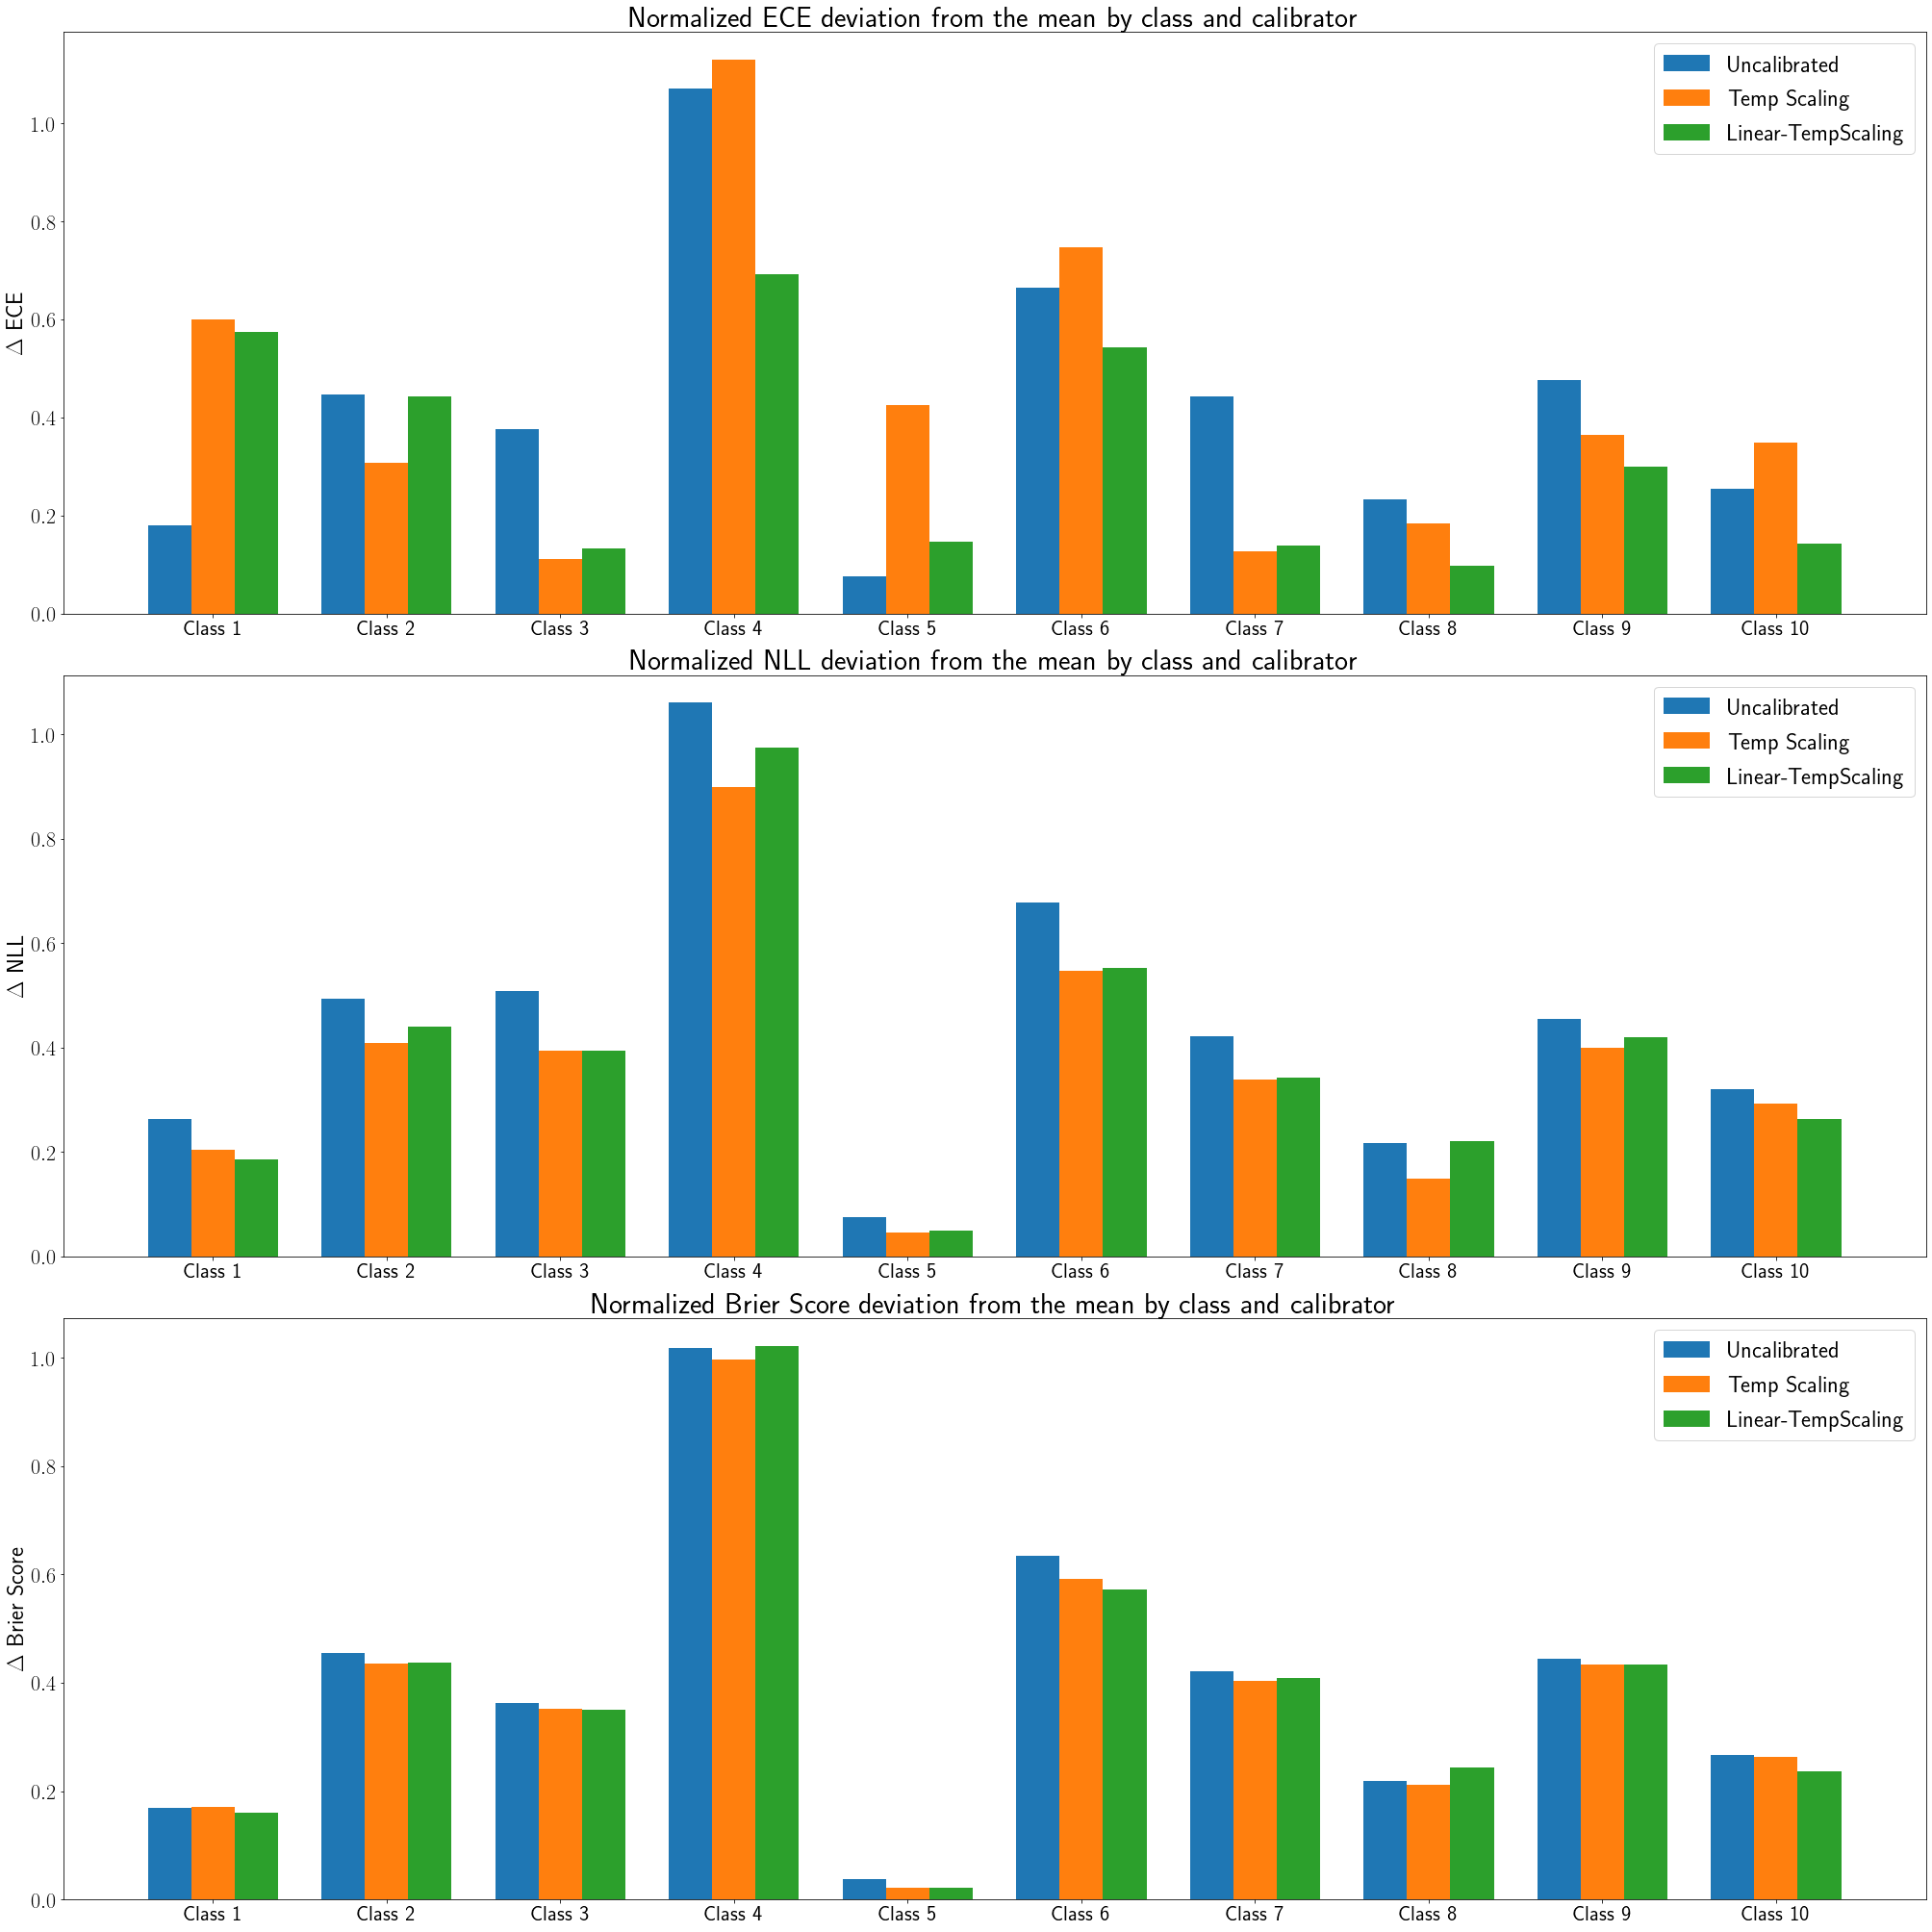

In [23]:
fig, ax = plt.subplots(3, 1, figsize=(28, 28))

# ECE
rects1 = ax[0].bar(x - width, np.abs(ece_uncal - ece_uncal.mean())/ece_uncal.mean(), width, label='Uncalibrated')
rects2 = ax[0].bar(x, np.abs(ece_TS - ece_TS.mean())/ece_TS.mean(), width, label='Temp Scaling')
rects3 = ax[0].bar(x + width, np.abs(ece_lTS - ece_lTS.mean())/ece_lTS.mean(), width, label='Linear-TempScaling')

ax[0].set_ylabel('$\Delta$ ECE', fontsize=24)
ax[0].set_title('Normalized ECE deviation from the mean by class and calibrator', fontsize=30)


# NLL
rects1 = ax[1].bar(x - width, np.abs(nll_uncal - nll_uncal.mean())/nll_uncal.mean(), width, label='Uncalibrated')
rects2 = ax[1].bar(x, np.abs(nll_TS - nll_TS.mean())/nll_TS.mean(), width, label='Temp Scaling')
rects3 = ax[1].bar(x + width, np.abs(nll_lTS - nll_lTS.mean())/nll_lTS.mean(), width, label='Linear-TempScaling')

ax[1].set_ylabel('$\Delta$ NLL', fontsize=24)
ax[1].set_title('Normalized NLL deviation from the mean by class and calibrator', fontsize=30)


# Brier
rects1 = ax[2].bar(x - width, np.abs(bri_uncal - bri_uncal.mean())/bri_uncal.mean(), width, label='Uncalibrated')
rects2 = ax[2].bar(x, np.abs(bri_TS - bri_TS.mean())/bri_TS.mean(), width, label='Temp Scaling')
rects3 = ax[2].bar(x + width, np.abs(bri_lTS - bri_lTS.mean())/bri_lTS.mean(), width, label='Linear-TempScaling')

ax[2].set_ylabel('$\Delta$  Brier Score', fontsize=24)
ax[2].set_title('Normalized Brier Score deviation from the mean by class and calibrator', fontsize=30)


for _ax in ax.flatten():
    _ax.set_xticks(x)
    _ax.set_xticklabels(labels)
    _ax.tick_params(axis='both', labelsize=22)
    _ax.legend(fontsize=24)

plt.tight_layout()
plt.show();

### Robustness to class-dependent distribution shift

In [24]:
CIFAR10C_PATH = '../../data/CIFAR-10-C'

In [25]:
cifar10c = get_CIFAR10_C(CIFAR10C_PATH)

categories = list(cifar10c.keys())
categories.remove('labels')

In [26]:
cifar10_transforms_test=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [27]:
net = load_model('resnet50', 'cifar10', model_path='../../trained_models') 

In [28]:
cifar10c_logits = {}

for category in categories:
    cifar10c_logits[category] = {}
    print('Computing predictions for corruption: {}'.format(category))
    for severity in range(1, 6):
        test_data = NumpyDataset(cifar10c[category][severity], cifar10c['labels'][:10000], transform=cifar10_transforms_test)
        test_dataloader = DataLoader(test_data, batch_size=256)
        cifar10c_logits[category][severity] = predict_logits(net, test_dataloader, torch.device('cuda'))

Computing predictions for corruption: brightness
Computing predictions for corruption: contrast
Computing predictions for corruption: defocus_blur
Computing predictions for corruption: elastic_transform
Computing predictions for corruption: fog
Computing predictions for corruption: frost
Computing predictions for corruption: gaussian_blur
Computing predictions for corruption: gaussian_noise
Computing predictions for corruption: glass_blur
Computing predictions for corruption: impulse_noise
Computing predictions for corruption: jpeg_compression
Computing predictions for corruption: motion_blur
Computing predictions for corruption: pixelate
Computing predictions for corruption: saturate
Computing predictions for corruption: shot_noise
Computing predictions for corruption: snow
Computing predictions for corruption: spatter
Computing predictions for corruption: speckle_noise
Computing predictions for corruption: zoom_blur


### Corrupt samples of class 5

In [29]:
Z_test_c = Z_test
Z_test_c[y_test==4] = cifar10c_logits['impulse_noise'][4][y_test==4] 

In [30]:
rnd_idx = np.random.permutation(10000)
idx_train = rnd_idx[:3000]
idx_test = rnd_idx[3000:]

In [31]:
### Temp-Scal as baseline:
tempScalerc = TempScaling()
tempScalerc.fit(Z_test_c[idx_train], y_test[idx_train], v=True);

In [32]:
laTempScalerc = AdaTS(LinearT(dim))
laTempScalerc = fitAdaTS(laTempScalerc, Z_test_c[idx_train], y_test[idx_train], epochs=20000, batch_size=1000, lr=1e-3, v=True)

In [33]:
print('##### Results on train set:')
compare_results(predictions={'Uncal': softmax(Z_test_c[idx_train], axis=1),
                             'TempScal': tempScalerc.predictive(Z_test_c[idx_train]),
                             'LinearAdaptiveTempScal': laTempScalerc.predictive(Z_test_c[idx_train])}, target=y_test[idx_train], from_logits=False);

##### Results on train set:
             Calibrator      Accuracy           ECE           MCE   Brier Score           NLL
Uncal                           83.17%        13.33%        41.74%    2.941e-01     9.902e-01
TempScal                        83.17%         3.77%        18.83%    2.453e-01     5.382e-01
LinearAdaptiveTempScal          83.17%         3.28%        15.60%    2.433e-01     5.288e-01


In [34]:
print('##### Results on test set:')
compare_results(predictions={'Uncal': softmax(Z_test_c[idx_test], axis=1),
                             'TempScal': tempScalerc.predictive(Z_test_c[idx_test]),
                             'LinearAdaptiveTempScal': laTempScalerc.predictive(Z_test_c[idx_test])}, target=y_test[idx_test], from_logits=False);

##### Results on test set:
             Calibrator      Accuracy           ECE           MCE   Brier Score           NLL
Uncal                           83.29%        12.86%        40.10%    2.880e-01     9.512e-01
TempScal                        83.29%         3.09%        19.89%    2.408e-01     5.265e-01
LinearAdaptiveTempScal          83.29%         2.60%        14.66%    2.389e-01     5.200e-01


In [35]:
preds_c = np.argmax(Z_test_c, axis=1)
P_c = softmax(Z_test_c, axis=1)

P_c_TS = tempScalerc.predictive(Z_test_c)

P_c_lTS = laTempScalerc.predictive(Z_test_c)

In [36]:
### ECE
ece_uncal = np.zeros(10)
ece_TS = np.zeros(10)
ece_lTS = np.zeros(10)

for c in range(10):
    ix = y_test[idx_test]==c
    ece_uncal[c] = compute_ece(P_c[idx_test][ix], y_test[idx_test][ix])
    ece_TS[c] = compute_ece(P_c_TS[idx_test][ix], y_test[idx_test][ix])
    ece_lTS[c] = compute_ece(P_c_lTS[idx_test][ix], y_test[idx_test][ix])

In [37]:
### nll
nll_uncal = np.zeros(10)
nll_TS = np.zeros(10)
nll_lTS = np.zeros(10)

for c in range(10):
    ix = y_test[idx_test]==c
    nll_uncal[c] = compute_nll(P_c[idx_test][ix], y_test[idx_test][ix], from_logits=False)
    nll_TS[c] = compute_nll(P_c_TS[idx_test][ix], y_test[idx_test][ix], from_logits=False)
    nll_lTS[c] = compute_nll(P_c_lTS[idx_test][ix], y_test[idx_test][ix], from_logits=False)

In [38]:
### bri
bri_uncal = np.zeros(10)
bri_TS = np.zeros(10)
bri_lTS = np.zeros(10)

for c in range(10):
    ix = y_test[idx_test]==c
    bri_uncal[c] = compute_brier(P_c[idx_test][ix], y_test[idx_test][ix])
    bri_TS[c] = compute_brier(P_c_TS[idx_test][ix], y_test[idx_test][ix])
    bri_lTS[c] = compute_brier(P_c_lTS[idx_test][ix], y_test[idx_test][ix])

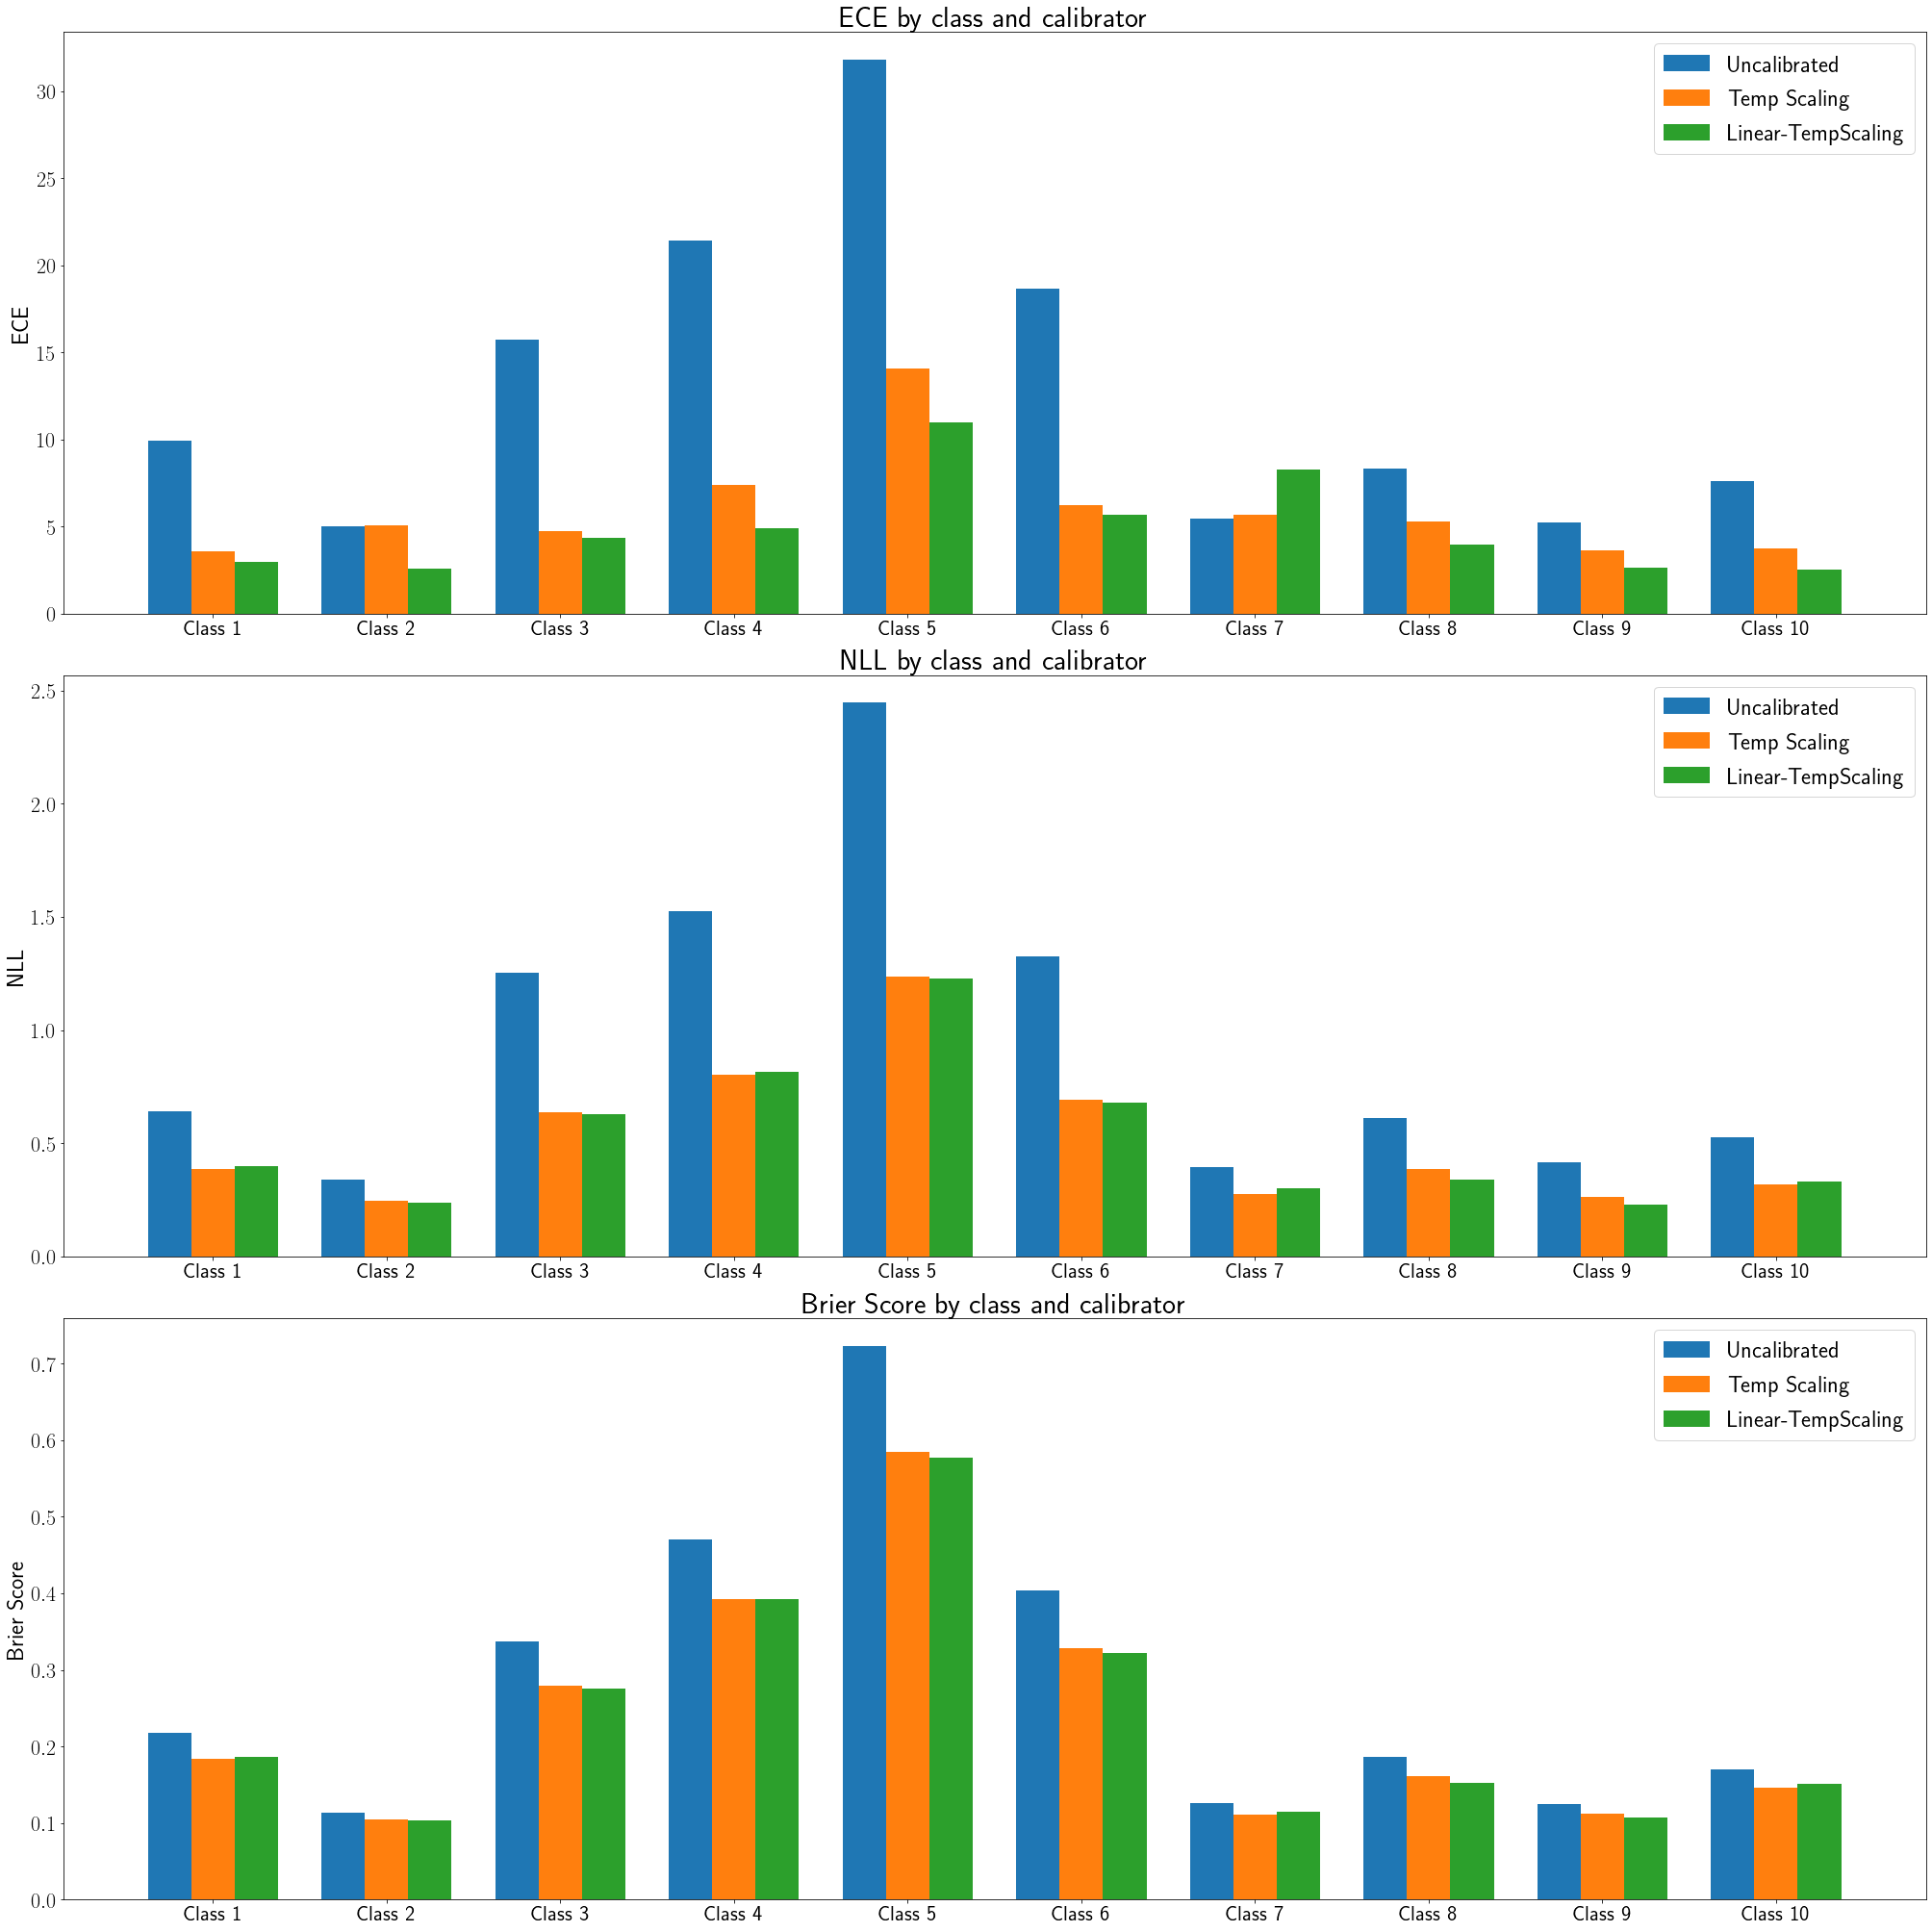

In [39]:
labels = ['Class {:d}'.format(i+1) for i in range(10)]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars


fig, ax = plt.subplots(3, 1, figsize=(28, 28))

# ECE
rects1 = ax[0].bar(x - width, ece_uncal, width, label='Uncalibrated')
rects2 = ax[0].bar(x, ece_TS, width, label='Temp Scaling')
rects3 = ax[0].bar(x + width, ece_lTS, width, label='Linear-TempScaling')

ax[0].set_ylabel('ECE', fontsize=24)
ax[0].set_title('ECE by class and calibrator', fontsize=30)


# NLL
rects1 = ax[1].bar(x - width, nll_uncal, width, label='Uncalibrated')
rects2 = ax[1].bar(x, nll_TS, width, label='Temp Scaling')
rects3 = ax[1].bar(x + width, nll_lTS, width, label='Linear-TempScaling')

ax[1].set_ylabel('NLL', fontsize=24)
ax[1].set_title('NLL by class and calibrator', fontsize=30)


# Brier
rects1 = ax[2].bar(x - width, bri_uncal, width, label='Uncalibrated')
rects2 = ax[2].bar(x, bri_TS, width, label='Temp Scaling')
rects3 = ax[2].bar(x + width, bri_lTS, width, label='Linear-TempScaling')

ax[2].set_ylabel('Brier Score', fontsize=24)
ax[2].set_title('Brier Score by class and calibrator', fontsize=30)


for _ax in ax.flatten():
    _ax.set_xticks(x)
    _ax.set_xticklabels(labels)
    _ax.tick_params(axis='both', labelsize=22)
    _ax.legend(fontsize=24)

plt.tight_layout()
plt.show();

In [44]:
Tsc = laTempScalerc.get_T(Z_test_c[idx_test])
Ts = laTempScaler.get_T(Z_test_c[idx_test])

In [45]:
### Optimum T per class

T_c = np.zeros(10)
for c in range(10):
    ts_aux = TempScaling()
    ts_aux.fit(Z_test_c[idx_test][y_test[idx_test]==c], y_test[idx_test][y_test[idx_test]==c]);
    T_c[c] = ts_aux.T.detach().numpy()

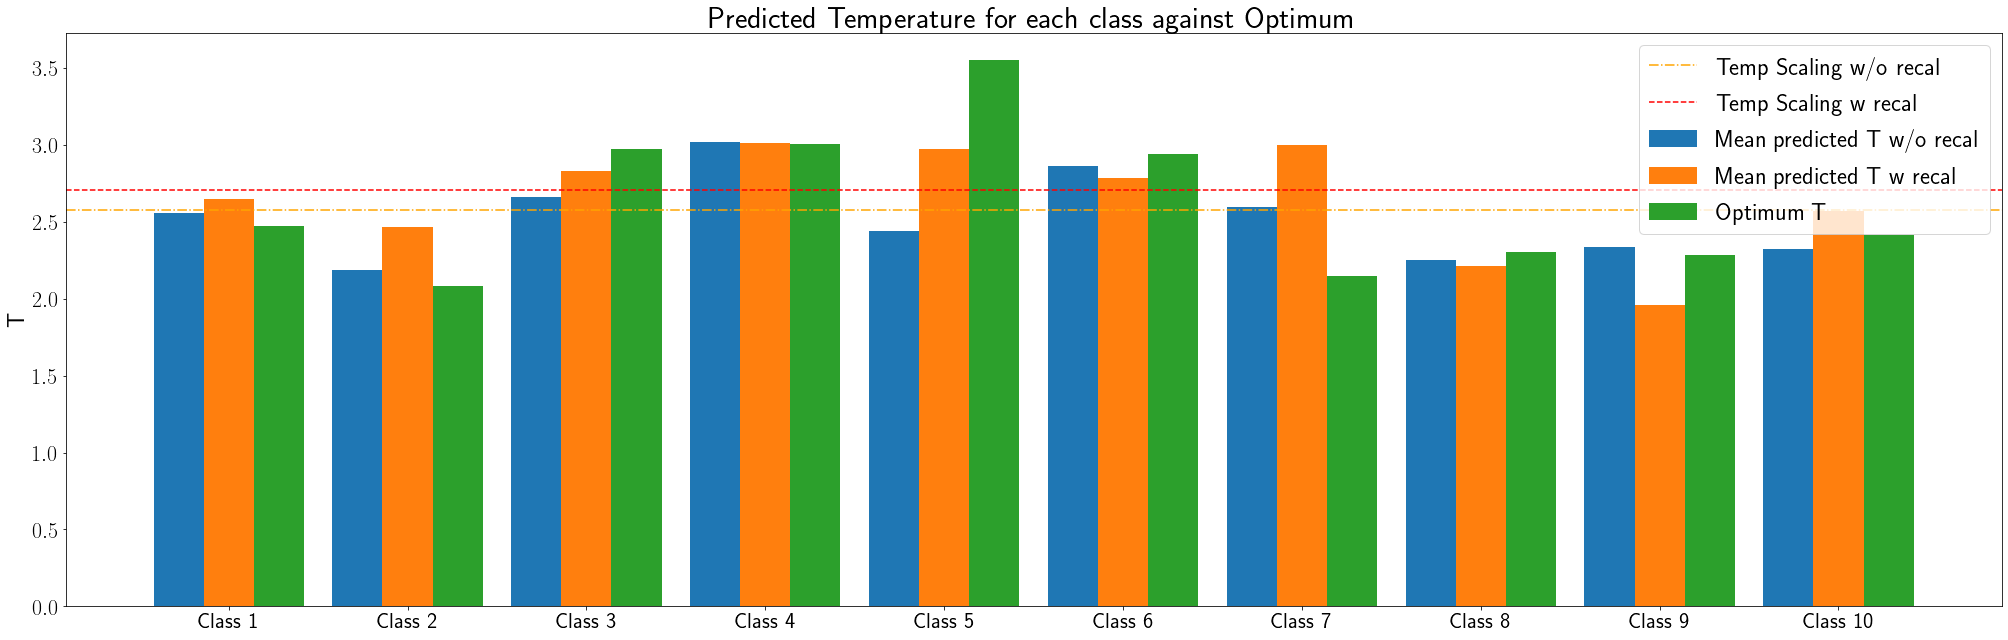

In [50]:
width = 0.28

fig, ax = plt.subplots(figsize=(28, 9))

rects1 = ax.bar(x - width, [np.mean(Ts[y_test[idx_test]==c]) for c in range(10)], width, label='Mean predicted T w/o recal')
rects2 = ax.bar(x, [np.mean(Tsc[y_test[idx_test]==c]) for c in range(10)], width, label='Mean predicted T w recal')
rects3 = ax.bar(x + width, T_c, width, label='Optimum T')
ax.axhline(tempScaler.T.item(), c='orange', ls='-.', label='Temp Scaling w/o recal')
ax.axhline(tempScalerc.T.item(), c='red', ls='--', label='Temp Scaling w recal')
ax.set_title('Predicted Temperature for each class against Optimum', fontsize=30)


ax.set_ylabel('T', fontsize=24)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.tick_params(axis='both', labelsize=22)
ax.legend(fontsize=24)

plt.tight_layout()
plt.show();